<a href="https://colab.research.google.com/github/papapabi/torch-sandbox/blob/main/timeseries_regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Timeseries modeling with LSTMs

## Hourly energy consumption dataset

PJM Interconnection LLC (PJM) is a regional transmission organization (RTO) in the United States. It is part of the Eastern Interconnection grid operating an electric transmission system serving all or parts of Delaware, Illinois, Indiana, Kentucky, Maryland, Michigan, New Jersey, North Carolina, Ohio, Pennsylvania, Tennessee, Virginia, West Virginia, and the District of Columbia.

The hourly power consumption data comes from PJM's website and are in megawatts (MW).

The regions have changed over the years so data may only appear for certain dates per region.

https://www.kaggle.com/datasets/robikscube/hourly-energy-consumption?select=PJME_hourly.csv

In [1]:
import pandas as pd

pd.options.display.max_columns = None

df = pd.read_csv("PJME_hourly.csv")

In [2]:
# Parse the 'datetime' column to python datetime objects
df['Datetime'] = pd.to_datetime(df['Datetime'])
# Optional but common practice for timeseries data and can simpify time-based filtering
df.set_index('Datetime', inplace=True)

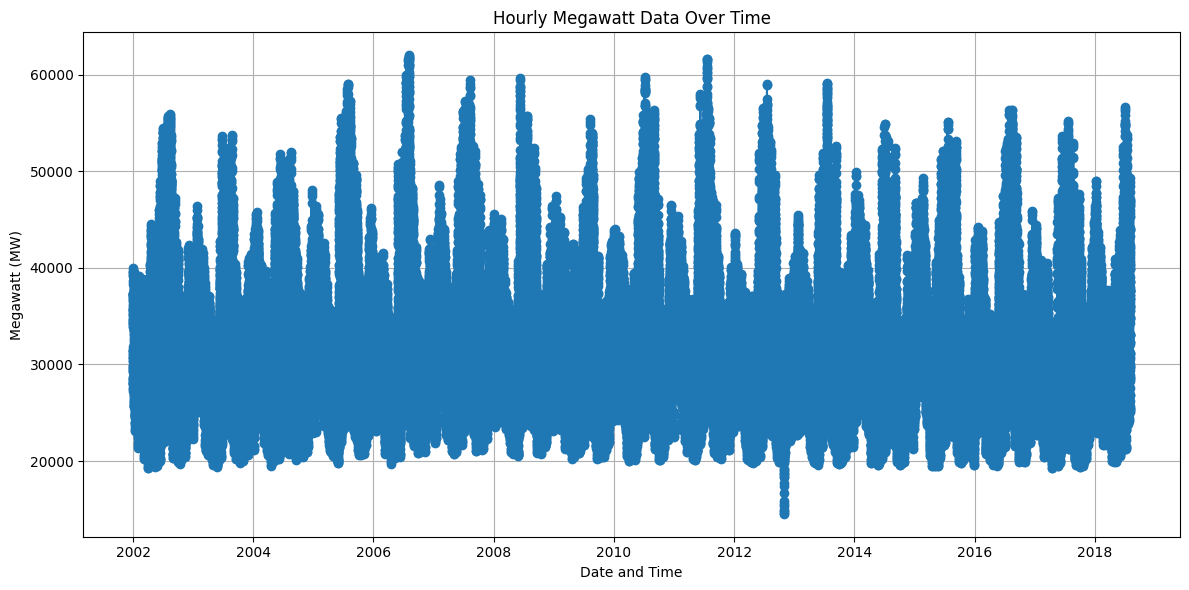

In [3]:
import matplotlib.pyplot as plt

# Plot the megawatt data over time
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['PJME_MW'], marker='o', linestyle='-')
plt.title('Hourly Megawatt Data Over Time')
plt.xlabel('Date and Time')
plt.ylabel('Megawatt (MW)')
plt.grid(True)
plt.tight_layout() # Adjust layout to prevent labels from overlapping
plt.show()


## Generating features from datetime objects

In [4]:
df_features = (df
    .assign(hour=df.index.hour)
    .assign(day=df.index.day)
    .assign(month=df.index.month)
    .assign(day_of_week=df.index.dayofweek)
    .assign(week_of_year=df.index.isocalendar().week)
)

In [5]:
df_features

,PJME_MW,hour,day,month,day_of_week,week_of_year
Datetime,,,,,,
2002-12-31 01:00:00,26498.0,1,31,12,1,1
2002-12-31 02:00:00,25147.0,2,31,12,1,1
2002-12-31 03:00:00,24574.0,3,31,12,1,1
2002-12-31 04:00:00,24393.0,4,31,12,1,1
2002-12-31 05:00:00,24860.0,5,31,12,1,1
...,...,...,...,...,...,...
2018-01-01 20:00:00,44284.0,20,1,1,0,1
2018-01-01 21:00:00,43751.0,21,1,1,0,1
2018-01-01 22:00:00,42402.0,22,1,1,0,1


## One-hot encoding

We can't directly use the numerical features created above as inputs for several crucial reasons:

1. False ordinality and magnitude - The model will assume an ordinal relationship when you feed in a numerical feature (e.g., hour 0-23). It interprets a higher number as "greater" than a lower number.
2. Cyclical nature ignored - hour, day of week, and month are cyclical. Direct numerical encoding fails to capture this cyclical relationship. The numerical distance between 23 and 0 is much larger than 0 and 1, which is illogical in the context of time.
3. Arbitrary numerical distance - the numerical difference between hour 1 and hour 2 is the same as between hour 10 and hour 11. While this is true in terms of time difference, it doesn't mean the impact on the target variable (MW) is linearly the same. For example, the difference in electricity consumption between 1AM and 2AM might be very different from the difference between 10AM and 11AM. A direct numerical input forces the model to treat these differences equally.

### Why one-hot encoding is preferred

One-hot encoding transforms each categorical value into a new binary (0 or 1) column.

No Assumed Ordinality:
* Each hour (e.g., hour_0, hour_1, ..., hour_23) becomes its own distinct feature.
* If the original hour was 5, the hour_5 column would be 1, and all other hour_X columns would be 0.
* The model then learns a separate, independent weight or effect for each specific hour. It doesn't assume that hour_20 is "more" than hour_10.

Captures Non-Linear and Specific Effects:

* This allows the model to learn that, for example, electricity consumption might be high at hour_8 (8 AM) and hour_17 (5 PM), but low at hour_3 (3 AM), without forcing any linear progression between these points. Each category can have a unique impact on the target variable.

Treats Categories as Distinct Entities:
* The model treats each hour, day of the week, or month as a distinct categorical variable rather than a continuous numerical one. This is crucial for features where the numbers are just labels for categories.

In [6]:
columns_to_encode = ['hour', 'day', 'month', 'day_of_week', 'week_of_year']

# `prefix` adds a string to the new column names (e.g., 'hour_0', 'hour_1')
# `drop_first=True` prevents multicollinearity (useful for linear models)
# by dropping the first category in each feature. If you have K categories,
# it creates K-1 new columns. The Kth category is implied when all K-1 are 0.
df_encoded = pd.get_dummies(df_features, columns=columns_to_encode, prefix=columns_to_encode, drop_first=True, dtype='int')

In [7]:
df_encoded

,PJME_MW,hour_1,hour_2,hour_3,hour_4,hour_5,hour_6,hour_7,hour_8,hour_9,hour_10,hour_11,hour_12,hour_13,hour_14,hour_15,hour_16,hour_17,hour_18,hour_19,hour_20,hour_21,hour_22,hour_23,day_2,day_3,day_4,day_5,day_6,day_7,day_8,day_9,day_10,day_11,day_12,day_13,day_14,day_15,day_16,day_17,day_18,day_19,day_20,day_21,day_22,day_23,day_24,day_25,day_26,day_27,day_28,day_29,day_30,day_31,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,day_of_week_1,day_of_week_2,day_of_week_3,day_of_week_4,day_of_week_5,day_of_week_6,week_of_year_2,week_of_year_3,week_of_year_4,week_of_year_5,week_of_year_6,week_of_year_7,week_of_year_8,week_of_year_9,week_of_year_10,week_of_year_11,week_of_year_12,week_of_year_13,week_of_year_14,week_of_year_15,week_of_year_16,week_of_year_17,week_of_year_18,week_of_year_19,week_of_year_20,week_of_year_21,week_of_year_22,week_of_year_23,week_of_year_24,week_of_year_25,week_of_year_26,week_of_year_27,week_of_year_28,week_of_year_29,week_of_year_30,week_of_year_31,week_of_year_32,week_of_year_33,week_of_year_34,week_of_year_35,week_of_year_36,week_of_year_37,week_of_year_38,week_of_year_39,week_of_year_40,week_of_year_41,week_of_year_42,week_of_year_43,week_of_year_44,week_of_year_45,week_of_year_46,week_of_year_47,week_of_year_48,week_of_year_49,week_of_year_50,week_of_year_51,week_of_year_52,week_of_year_53
Datetime,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2002-12-31 01:00:00,26498.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2002-12-31 02:00:00,25147.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2002-12-31 03:00:00,24574.0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2002-12-31 04:00:00,24393.0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2002-12-31 05:00:00,24860.0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-01-01 20:00:00,44284.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2018-01-01 21:00:00,43751.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2018-01-01 22:00:00,42402.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0

## Holidays as a feature

In [8]:
#!pip install holidays

In [9]:
from datetime import date

import holidays


min_year = df.index.min().year
max_year = df.index.max().year

# Generate us holidays for the relevant years
# observed=True includes observed holidays when they fall on a weekend
# observed=True is crucial because many federal holidays are observed on a Monday if they fall on a weekend
us_holidays = holidays.US(years=range(min_year, max_year + 1), observed=True)

# using a set makes lookup extremely fast
us_holiday_dates = set(dt for dt in us_holidays.keys())

df_encoded['holiday'] = 0
df_encoded['holiday'] = df.index.normalize().isin(us_holiday_dates).astype(int)

df_encoded

/tmp/ipython-input-9-3033332793.py:18: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  df_encoded['holiday'] = df.index.normalize().isin(us_holiday_dates).astype(int)


,PJME_MW,hour_1,hour_2,hour_3,hour_4,hour_5,hour_6,hour_7,hour_8,hour_9,hour_10,hour_11,hour_12,hour_13,hour_14,hour_15,hour_16,hour_17,hour_18,hour_19,hour_20,hour_21,hour_22,hour_23,day_2,day_3,day_4,day_5,day_6,day_7,day_8,day_9,day_10,day_11,day_12,day_13,day_14,day_15,day_16,day_17,day_18,day_19,day_20,day_21,day_22,day_23,day_24,day_25,day_26,day_27,day_28,day_29,day_30,day_31,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,day_of_week_1,day_of_week_2,day_of_week_3,day_of_week_4,day_of_week_5,day_of_week_6,week_of_year_2,week_of_year_3,week_of_year_4,week_of_year_5,week_of_year_6,week_of_year_7,week_of_year_8,week_of_year_9,week_of_year_10,week_of_year_11,week_of_year_12,week_of_year_13,week_of_year_14,week_of_year_15,week_of_year_16,week_of_year_17,week_of_year_18,week_of_year_19,week_of_year_20,week_of_year_21,week_of_year_22,week_of_year_23,week_of_year_24,week_of_year_25,week_of_year_26,week_of_year_27,week_of_year_28,week_of_year_29,week_of_year_30,week_of_year_31,week_of_year_32,week_of_year_33,week_of_year_34,week_of_year_35,week_of_year_36,week_of_year_37,week_of_year_38,week_of_year_39,week_of_year_40,week_of_year_41,week_of_year_42,week_of_year_43,week_of_year_44,week_of_year_45,week_of_year_46,week_of_year_47,week_of_year_48,week_of_year_49,week_of_year_50,week_of_year_51,week_of_year_52,week_of_year_53,holiday
Datetime,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2002-12-31 01:00:00,26498.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2002-12-31 02:00:00,25147.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2002-12-31 03:00:00,24574.0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2002-12-31 04:00:00,24393.0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2002-12-31 05:00:00,24860.0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-01-01 20:00:00,44284.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2018-01-01 21:00:00,43751.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2018-01-01 22:00:00,42402.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,

## Creating train/val/test splits

Crucial Point: Data Leakage Prevention

Always fit your scaler only on your training data and then transform both your training and test/validation sets using that fitted scaler. Never fit the scaler on your entire dataset (including test data) before splitting, as this would cause data leakage.

In [10]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

train_ratio = 0.6
val_ratio = 0.2
test_ratio = 0.2

# Chronological split instead of using train_test_split to avoid
# data leakage where information from the future leaks into the past
total_rows = len(df_encoded)
train_split_point = int(total_rows * train_ratio)
val_split_point = int(total_rows * (train_ratio + val_ratio))

# Split before scaling to prevent data leakage
# If we had scaled before splitting, the scaling process would implicitly use
# statistics (mean/std dev) from the validation and test sets, contaminating training
df_train = df_encoded.iloc[:train_split_point]
df_val = df_encoded.iloc[train_split_point:val_split_point]
df_test = df_encoded.iloc[val_split_point:]

print(f"Training set shape: {df_train.shape} (from {df_train.index.min().date()} to {df_train.index.max().date()})")
print(f"Validation set shape: {df_val.shape} (from {df_val.index.min().date()} to {df_val.index.max().date()})")
print(f"Test set shape: {df_test.shape} (from {df_test.index.min().date()} to {df_test.index.max().date()})")

Training set shape: (87219, 124) (from 2002-01-01 to 2012-01-01)
Validation set shape: (29073, 124) (from 2011-01-01 to 2016-01-01)
Test set shape: (29074, 124) (from 2015-01-01 to 2018-08-03)


In [11]:
scaler = MinMaxScaler()

# Fit the scaler ONLY on the training data
# Learn the mean and standard dev only from the training data
columns_to_scale = ['PJME_MW']
scaler.fit(df_train[columns_to_scale])

# Transform all three sets using the fitted scaler
df_train_scaled = df_train.copy()
df_val_scaled = df_val.copy()
df_test_scaled = df_test.copy()

# Then apply the same learned mu and sigma values to transform all 3 datasets
df_train_scaled[columns_to_scale] = scaler.transform(df_train_scaled[columns_to_scale])
df_val_scaled[columns_to_scale] = scaler.transform(df_val_scaled[columns_to_scale])
df_test_scaled[columns_to_scale] = scaler.transform(df_test_scaled[columns_to_scale])


## Creating a custom `torch.utils.data.Dataset`

In [12]:
import torch

import numpy as np

class EnergyConsumptionDataset(torch.utils.data.Dataset):
    def __init__(self, dataframe, target_column='PJME_MW'):
        """
        Args:
            dataframe (pd.DataFrame): The input DataFrame containing features and target.
            feature_columns (list): A list of column names to be used as features.
            target_column (str): The name of the column to be used as the target.
        """
        super(EnergyConsumptionDataset, self).__init__()

        # Convert both to numpy arrays
        self.targets = dataframe[target_column].values
        self.features = dataframe.drop(columns=[target_column]).values

        # Ensure data types are float32 for PyTorch compatibility
        # Even though the features are one-hot encoded, we still need to set
        # dtype as float32 - as PyTorch expects inputs to be floating point nums
        self.features = self.features.astype(np.float32)
        self.targets = self.targets.astype(np.float32)

    def __len__(self):
        """Returns the total number of samples."""
        return len(self.features)

    def __getitem__(self, idx):
        """
        Retrieves a single sample by index.
        Args:
            idx (int): The index of the sample to retrieve.
        Returns:
            tuple: (features_tensor, target_tensor)
        """
        feature_tensor = torch.tensor(self.features[idx])
        target_tensor = torch.tensor(self.targets[idx]).unsqueeze(0) # Unsqueeze for a (1,) shape for single output

        return feature_tensor, target_tensor

In [13]:
train_ds = EnergyConsumptionDataset(df_train_scaled)
val_ds = EnergyConsumptionDataset(df_val_scaled)
test_ds = EnergyConsumptionDataset(df_test_scaled)


In [14]:
features, targets = train_ds[0]
print(features.shape)
print(targets.shape)
print(features)
print(targets)

torch.Size([123])
torch.Size([1])
tensor([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
tensor([0.1696])


## Creating `torch.utils.data.DataLoader`s

In [15]:
batch_size = 256

train_dl = torch.utils.data.DataLoader(train_ds, batch_size=batch_size, shuffle=False, drop_last=True)
val_dl = torch.utils.data.DataLoader(val_ds, batch_size=batch_size, shuffle=False, drop_last=True)
test_dl = torch.utils.data.DataLoader(test_ds, batch_size=batch_size, shuffle=False, drop_last=True)

In [16]:
print(train_dl)

## Training and evaluation code

In [17]:
import time

import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import Dataset, DataLoader

from tqdm.autonotebook import tqdm

/tmp/ipython-input-17-739575990.py:12: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [18]:
from collections.abc import Mapping, Sequence

def move(obj, device):
    """
    Recursively moves PyTorch tensors and modules within a Python object to a specified device.

    Args:
        obj: The Python object to move to a device, or to move its contents to a device.
             Can be a torch.Tensor, torch.nn.Module, list, tuple, set, dict, or other types.
        device: The compute device (e.g., 'cpu', 'cuda:0') to move objects to.

    Returns:
        The object with its PyTorch components moved to the specified device.
    """
    if isinstance(obj, torch.Tensor):
        return obj.to(device)
    elif isinstance(obj, torch.nn.Module):
        return obj.to(device)
    elif isinstance(obj, Mapping):
        return {k: move(v, device) for k, v in obj.items()}
    elif isinstance(obj, Sequence) and not isinstance(obj, str): # Exclude strings as they are sequences of chars
        return type(obj)(move(x, device) for x in obj)
    else:
        return obj

In [19]:
def run_epoch(model, optimizer, data_loader, loss_func, device, results, score_funcs, prefix="", desc=None, scaler=None):
    """
    Runs a single epoch of training or validation in PyTorch.

    Args:
        model (torch.nn.Module): The PyTorch model to run for one epoch.
        optimizer (torch.optim.Optimizer): The object that will update the weights of the network.
                                           Pass None if in evaluation mode (no optimization needed).
        data_loader (torch.utils.data.DataLoader): DataLoader object that returns tuples of (input, label) pairs.
        loss_func (callable): The loss function that takes in two arguments (model outputs, labels)
                              and returns a scalar loss.
        device (torch.device or str): The compute location to perform training/evaluation (e.g., 'cpu', 'cuda:0').
        results (dict): A dictionary to store epoch-wise metrics.
        score_funcs (dict): A dictionary of scoring functions (name: function) to use to evaluate
                            the performance of the model. Each function should take (y_true, y_pred).
        prefix (str): A string to prefix to any scores placed into the `results` dictionary.
                      Commonly 'train_' or 'val_'.
        desc (str, optional): A description to use for the progress bar.
        scaler: (sklearn.preprocessing.BaseScaler, optional): An optional scaler for target variables when scaling is applied during preprocessing.

    Returns:
        float: Time spent on the epoch in seconds.
    """
    running_loss = []
    y_true_all = []
    y_pred_all = []

    start = time.time()

    # Set model to training or evaluation mode
    # NOTE: Layers like Dropout and BatchNorm behave differently during training and evaluation.
    # model.train() enables their training-specific behavior (e.g., dropout randomness, batch norm updating running stats),
    # while model.eval() sets them to evaluation mode (e.g., no dropout, batch norm using learned running stats)
    if optimizer is not None:
        model.train()
        # Enable anomaly detection for debugging during training
        # with torch.autograd.set_detect_anomaly(True): # Uncomment for debugging
        #     for inputs, labels in tqdm(data_loader, desc=desc, leave=False):
        #         ...
    else:
        model.eval()


    # Use torch.no_grad() for evaluation phase to save memory and speed up
    # computations by not building the computational graph.
    with torch.no_grad() if optimizer is None else torch.enable_grad():
        for inputs, labels in tqdm(data_loader, desc=desc, leave=False):
            # Move the batch to the device we are using.
            inputs = move(inputs, device)
            labels = move(labels, device)

            # Forward pass
            y_hat = model(inputs)

            # Compute loss
            loss = loss_func(y_hat, labels)

            if model.training:
                loss.backward()
                optimizer.step()
                optimizer.zero_grad()

            # Use .item() for scalar loss to prevent memory leaks in the computational graph
            running_loss.append(loss.item())

            # Collect predictions and true labels for metric calculation
            # It's generally good practice to keep these on CPU for metric calculation
            # and to convert to numpy for compatibility with libraries like scikit-learn.
            # Only process if score_funcs are provided and labels are tensors.
            if len(score_funcs) > 0 and isinstance(labels, torch.Tensor):
                # Detach from graph, move to CPU, convert to numpy
                # For classification, often want raw logits for metrics,
                # then apply argmax for accuracy.
                # For regression, y_hat is already numerical.
                labels_np = labels.detach().cpu().numpy()
                y_hat_np = y_hat.detach().cpu().numpy()

                # Extend with current batch's data
                y_true_all.extend(labels_np.tolist())
                y_pred_all.extend(y_hat_np.tolist())

    # End training/evaluation epoch
    end = time.time()

    # Post-epoch metric calculations
    y_pred_final = np.asarray(y_pred_all)
    y_true_final = np.asarray(y_true_all) # Ensure y_true is also a numpy array

    # Handle classification output (e.g., logits to class predictions)
    # This logic assumes `y_pred_all` contains raw model outputs (logits or probabilities)
    # and `y_true_all` contains integer class labels for classification, or continuous values for regression.
    if y_pred_final.size > 0 and len(y_pred_final.shape) == 2 and y_pred_final.shape[1] > 1:
        # Assuming multi-class classification where y_hat are logits/probabilities
        y_pred_final_processed = np.argmax(y_pred_final, axis=1)
    else:
        # Assume regression or binary classification (where y_hat might be a single value)
        y_pred_final_processed = y_pred_final

    # Store results
    results[prefix + " loss"].append(np.mean(running_loss))

    if scaler:
        y_true_final = scaler.inverse_transform(y_true_final)
        y_pred_final_processed = scaler.inverse_transform(y_pred_final_processed)

    for name, score_func in score_funcs.items():
        try:
            # Pass the processed predictions and true labels to score functions
            results[prefix + " " + name].append(score_func(y_true_final, y_pred_final_processed))
        except Exception as e: # Catch specific exception or general Exception
            print(f"Warning: Error calculating score '{name}': {e}. Appending NaN.")
            results[prefix + " " + name].append(float("NaN"))

    return end - start # time spent on epoch

In [20]:
import os

from typing import Callable, Optional, Union, Dict, Any
from collections import defaultdict

def train_network(
    model: nn.Module,
    loss_func: Callable[[torch.Tensor, torch.Tensor], torch.Tensor],
    train_loader: DataLoader,
    val_loader: Optional[DataLoader] = None,
    score_funcs: Optional[Dict[str, Callable[[Any, Any], float]]] = None,
    epochs: int = 50,
    device: Union[str, torch.device] = "cpu",
    checkpoint_file: Optional[str] = None,
    lr_schedule: Optional[torch.optim.lr_scheduler._LRScheduler] = None,
    optimizer: Optional[torch.optim.Optimizer] = None,
    disable_tqdm: bool = False,
    scaler=None,
) -> pd.DataFrame:
    """
    Trains a PyTorch neural network.

    Args:
        model: The PyTorch model to train.
        loss_func: The loss function that takes in model outputs and labels, and returns a scalar loss.
        train_loader: PyTorch DataLoader for training data.
        val_loader: Optional PyTorch DataLoader for validation data, evaluated after each epoch.
        score_funcs: A dictionary of scoring functions (name: function) to evaluate model performance.
                     Each function should take (y_true, y_pred).
        epochs: The number of training epochs to perform.
        device: The compute location (e.g., 'cpu', 'cuda:0') to perform training.
        checkpoint_file: Optional path to a file for saving/loading model checkpoints.
        lr_schedule: The learning rate scheduler. If provided, `optimizer` must also be provided.
        optimizer: The optimizer used to update model parameters. If None, AdamW is used by default.
        disable_tqdm: If True, disables the progress bar.
        scaler: (sklearn.preprocessing.BaseScaler, optional): An optional scaler for target variables when scaling is applied during preprocessing.

    Returns:
        pd.DataFrame: A DataFrame containing epoch-wise training, validation, and test results.
    """
    if score_funcs is None:
        score_funcs = {}

    # Initialize results dictionary using defaultdict for cleaner appending
    results: Dict[str, list] = defaultdict(list)

    # Move model to the specified device
    model.to(device)

    if optimizer is None:
        print("Optimizer not provided. Using AdamW as default.")
        optimizer = torch.optim.AdamW(model.parameters())

    start_epoch = 0
    # Load from checkpoint if specified and exists
    if checkpoint_file and os.path.exists(checkpoint_file):
        print(f"Loading checkpoint from {checkpoint_file}...")
        checkpoint = torch.load(checkpoint_file, map_location=device)
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        start_epoch = checkpoint['epoch'] + 1
        # Restore results if available
        if 'results' in checkpoint:
            # Ensure loaded results are compatible with defaultdict if needed
            for k, v in checkpoint['results'].items():
                results[k] = v
        print(f"Resuming training from epoch {start_epoch}.")
    elif checkpoint_file and not os.path.exists(checkpoint_file):
        print(f"Checkpoint file '{checkpoint_file}' not found. Starting training from scratch.")

    total_train_time = sum(results.get("total time", [0])) # Accumulate time if resuming

    # Main training loop
    for epoch in tqdm(range(start_epoch, epochs), desc="Overall Epoch", disable=disable_tqdm):
        # --- Training Phase ---
        print(f"\nEpoch {epoch+1}/{epochs} - Training...")
        current_epoch_train_time = run_epoch(
            model, optimizer, train_loader, loss_func, device,
            results, score_funcs, prefix="train", desc="Training Batch", scaler=scaler,
        )
        total_train_time += current_epoch_train_time

        results["epoch"].append(epoch)
        results["total time"].append(total_train_time)

        # --- Validation Phase ---
        if val_loader is not None:
            print(f"Epoch {epoch+1}/{epochs} - Validating...")
            # optimizer=None ensures run_epoch is in evaluation mode
            run_epoch(
                model, None, val_loader, loss_func, device,
                results, score_funcs, prefix="val", desc="Validation Batch", scaler=scaler,
            )

        # --- Learning Rate Schedule Step ---
        if lr_schedule is not None:
            if isinstance(lr_schedule, torch.optim.lr_scheduler.ReduceLROnPlateau):
                # ReduceLROnPlateau needs a metric; typically validation loss
                if val_loader is not None and "val loss" in results and len(results["val loss"]) > 0:
                    lr_schedule.step(results["val loss"][-1])
                else:
                    print("Warning: ReduceLROnPlateau scheduler requires validation loss but 'val_loader' is None or 'val loss' not found. Skipping step.")
            else:
                lr_schedule.step()
            print(f"Learning rate adjusted to: {optimizer.param_groups[0]['lr']:.6f}")

        # --- Checkpointing ---
        if checkpoint_file is not None:
            try:
                torch.save({
                    'epoch': epoch,
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'lr_scheduler_state_dict': lr_schedule.state_dict() if lr_schedule else None,
                    'results': dict(results) # Convert defaultdict to dict for saving
                }, checkpoint_file)
                print(f"Checkpoint saved to {checkpoint_file} at end of epoch {epoch+1}")
            except Exception as e:
                print(f"Error saving checkpoint: {e}")

    print("\nTraining complete!")
    return pd.DataFrame.from_dict(results)

In [21]:
def eval_network(
    model: nn.Module,
    loss_func: Callable[[torch.Tensor, torch.Tensor], torch.Tensor],
    test_loader: DataLoader,
    score_funcs: Optional[Dict[str, Callable[[Any, Any], float]]] = None,
    device: Union[str, torch.device] = "cpu",
    checkpoint_file: Optional[str] = None,
    disable_tqdm: bool = False,
    scaler=None,
) -> Dict[str, float]:
    """
    Evaluates a PyTorch neural network on a held-out test set.

    Args:
        model: The PyTorch model to evaluate.
        loss_func: The loss function that takes in model outputs and labels, and returns a scalar loss.
        test_loader: PyTorch DataLoader for the test data.
        score_funcs: A dictionary of scoring functions (name: function) to evaluate model performance.
                     Each function should take (y_true, y_pred).
        device: The compute location (e.g., 'cpu', 'cuda:0') to perform evaluation.
        checkpoint_file: Optional path to a file for loading a pre-trained model checkpoint.
        disable_tqdm: If True, disables the progress bar.

    Returns:
        Dict[str, float]: A dictionary containing the evaluation loss and scores.
    """
    if score_funcs is None:
        score_funcs = {}

    # Move model to the specified device
    model.to(device)

    # Load from checkpoint if specified and exists
    if checkpoint_file and os.path.exists(checkpoint_file):
        print(f"Loading model from checkpoint: {checkpoint_file} for evaluation...")
        checkpoint = torch.load(checkpoint_file, map_location=device)
        model.load_state_dict(checkpoint['model_state_dict'])
        print("Model loaded successfully.")
    elif checkpoint_file and not os.path.exists(checkpoint_file):
        print(f"Warning: Checkpoint file '{checkpoint_file}' not found. Evaluating with current model state.")

    # Set model to evaluation mode
    model.eval()

    running_loss = []
    y_true_all = []
    y_pred_all = []

    start = time.time()

    with torch.no_grad():
        for inputs, labels in tqdm(test_loader, desc="Evaluating Test Set", leave=False, disable=disable_tqdm):
            inputs = move(inputs, device)
            labels = move(labels, device)

            y_hat = model(inputs)
            loss = loss_func(y_hat, labels)
            running_loss.append(loss.item())

            if len(score_funcs) > 0 and isinstance(labels, torch.Tensor):
                labels_np = labels.detach().cpu().numpy()
                y_hat_np = y_hat.detach().cpu().numpy()

                y_true_all.extend(labels_np.tolist())
                y_pred_all.extend(y_hat_np.tolist())

    end = time.time()
    eval_time = end - start

    # Post-evaluation metric calculations
    y_pred_final = np.asarray(y_pred_all)
    y_true_final = np.asarray(y_true_all)

    if y_pred_final.size > 0 and len(y_pred_final.shape) == 2 and y_pred_final.shape[1] > 1:
        y_pred_final_processed = np.argmax(y_pred_final, axis=1)
    else:
        y_pred_final_processed = y_pred_final

    final_results: Dict[str, float] = {}
    final_results["test loss"] = np.mean(running_loss)
    final_results["test_eval_time_seconds"] = eval_time

    if scaler:
        y_true_final = scaler.inverse_transform(y_true_final)
        y_pred_final_processed = scaler.inverse_transform(y_pred_final_processed)

    for name, score_func in score_funcs.items():
        try:
            final_results[f"test {name}"] = score_func(y_true_final, y_pred_final_processed)
        except Exception as e:
            print(f"Warning: Error calculating score '{name}' during test evaluation: {e}. Setting to NaN.")
            final_results[f"test {name}"] = float("NaN")

    print(f"\nTest Evaluation Complete. Time: {eval_time:.2f} seconds.")
    print("Test Results:")
    for metric, value in final_results.items():
        print(f"  {metric}: {value:.4f}")

    return final_results

## Defining the model

In [22]:
import torch.nn as nn

class LSTMModel(nn.Module):
    """LSTMModel class extends nn.Module class and works as a constructor for LSTMs.

       LSTMModel class initiates a LSTM module based on PyTorch's nn.Module class.
       It has only two methods, namely init() and forward(). While the init()
       method initiates the model with the given input parameters, the forward()
       method defines how the forward propagation needs to be calculated.
       Since PyTorch automatically defines back propagation, there is no need
       to define back propagation method.

       Attributes:
           hidden_dim (int): The number of nodes in each layer
           layer_dim (str): The number of layers in the network
           lstm (nn.LSTM): The LSTM model constructed with the input parameters.
           fc (nn.Linear): The fully connected layer to convert the final state
                           of LSTMs to our desired output shape.

    """
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim, dropout_prob):
        """The __init__ method that initiates a LSTM instance.

        Args:
            input_dim (int): The number of nodes in the input layer
            hidden_dim (int): The number of nodes in each layer
            layer_dim (int): The number of layers in the network
            output_dim (int): The number of nodes in the output layer
            dropout_prob (float): The probability of nodes being dropped out

        """
        super(LSTMModel, self).__init__()

        # Defining the number of layers and the nodes in each layer
        self.hidden_dim = hidden_dim
        self.layer_dim = layer_dim

        # LSTM layers
        self.lstm = nn.LSTM(
            input_dim, hidden_dim, layer_dim, batch_first=True, dropout=dropout_prob
        )

        # Fully connected layer
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        """The forward method takes input tensor x and does forward propagation

        Args:
            x (torch.Tensor): The input tensor of the shape (batch size, input_dim)

        Returns:
            torch.Tensor: The output tensor of the shape (batch size, output_dim)

        """
        # Reshape input to (batch_size, seq_len, input_dim)
        x = x.view([batch_size, -1, input_dim])
        #x = x.unsqueeze(1)

        # Initializing hidden state for first input with zeros
        h0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim,device=x.device).requires_grad_()

        # Initializing cell state for first input with zeros
        c0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim,device=x.device).requires_grad_()

        # We need to detach as we are doing truncated backpropagation through time (BPTT)
        # If we don't, we'll backprop all the way to the start even after going through another batch
        # Forward propagation by passing in the input, hidden state, and cell state into the model
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))

        # Reshaping the outputs in the shape of (batch_size, seq_length, hidden_size)
        # so that it can fit into the fully connected layer
        out = out[:, -1, :]

        # Convert the final state to our desired output shape (batch_size, output_dim)
        out = self.fc(out)

        return out

In [23]:
import math
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

def root_mean_squared_error(y_true, y_pred):
    return math.sqrt(mean_squared_error(y_true, y_pred))

input_dim = 123 # features.shape
output_dim = 1 # target
hidden_dim = 128
layer_dim = 3
dropout_prob = 0.2

loss_func = torch.nn.MSELoss()
score_funcs = {"r2": r2_score, "MAE": mean_absolute_error, "RMSE": root_mean_squared_error}
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [24]:
lstm_model = LSTMModel(input_dim=input_dim, hidden_dim=hidden_dim, layer_dim=layer_dim, output_dim=output_dim, dropout_prob=dropout_prob)

In [ ]:
lstm_results = train_network(model=lstm_model, loss_func=loss_func, train_loader=train_dl, val_loader=val_dl, score_funcs=score_funcs, epochs=30, device=device, scaler=scaler)

<Axes: xlabel='epoch', ylabel='train loss'>

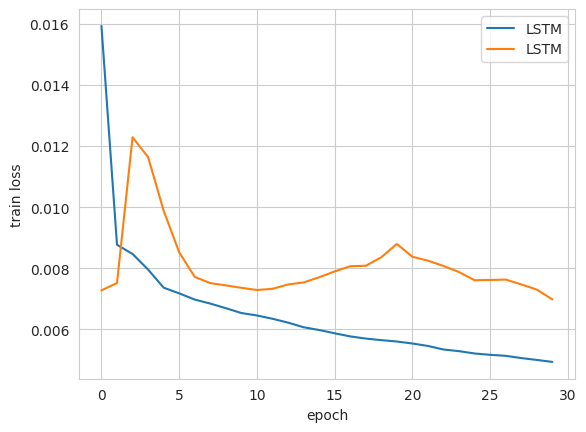

In [26]:
import seaborn as sns

sns.set_style("whitegrid")
sns.lineplot(x='epoch', y='train loss', data=lstm_results, label='LSTM')
sns.lineplot(x='epoch', y='val loss', data=lstm_results, label='LSTM')

<Axes: xlabel='epoch', ylabel='train MAE'>

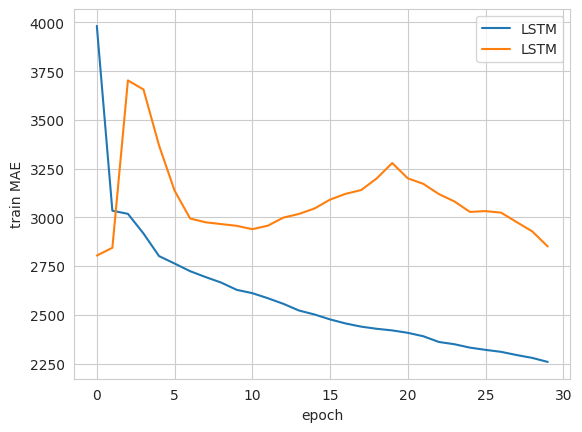

In [27]:
sns.lineplot(x='epoch', y='train MAE', data=lstm_results, label='LSTM')
sns.lineplot(x='epoch', y='val MAE', data=lstm_results, label='LSTM')

In [ ]:
lstm_eval_results = eval_network(model=lstm_model, loss_func=loss_func, test_loader=test_dl, score_funcs=score_funcs, device=device, scaler=scaler)

In [30]:
lstm_eval_results

{'test loss': np.float64(0.009081226406800272),
 'test_eval_time_seconds': 1.9184668064117432,
 'test r2': 0.6069053550946999,
 'test MAE': 3280.112863720822,
 'test RMSE': 4075.024850045889}